<a href="https://colab.research.google.com/github/tevrat-aksoy/Denoising_Autoencoder/blob/main/denoising_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BM5041 Bilgisayarla Görme Bahar 2021**


---
**CHARMANDER**


---


**Görüntü İyileşirme**

Kullanılacak kütüphaneler import edilir. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array

from tensorflow.keras.preprocessing import image_dataset_from_directory


Veri setlerinin bulunduğu klasör seçilir.

In [ ]:
import pathlib
dataset_path="../input/landmarkdata/GoogleLandmarksDataset"


Giriş görüntüleri 256x256 boyutuna çevrilir.

In [ ]:
batch_size = 10
input_shape = (256, 256)

Gauss gürültüsü oluşturma fonksiyonu tanımlanır.

In [ ]:
import skimage
def GaussNoise(images):
    for noisyImages, OrgImages in images:

        noisyImages=skimage.util.random_noise(noisyImages, mode='gaussian', seed=None, clip=True,mean=0.2)
        
        yield (noisyImages, OrgImages)


Tuz-biber gürültüsü oluşturma fonksiyonu tanımlanır.

In [ ]:
import skimage
def SaltandPaperNoise(images):
    for noisyImages, OrgImages in images:

        noisyImages=skimage.util.random_noise(noisyImages, mode='s&p', seed=None, clip=True,amount=0.2)
        
        yield (noisyImages, OrgImages)


Görüntüler farklı batchlere ayrılır.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1/255,)

testImages = test_datagen.flow_from_directory(
    dataset_path + '/test/test',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='input',
interpolation='nearest',)

testNoisyBatch = GaussNoise(testImages)

Found 1002 images belonging to 1 classes.


In [ ]:
testNoisyImages, testOrgImages = next(testNoisyBatch)

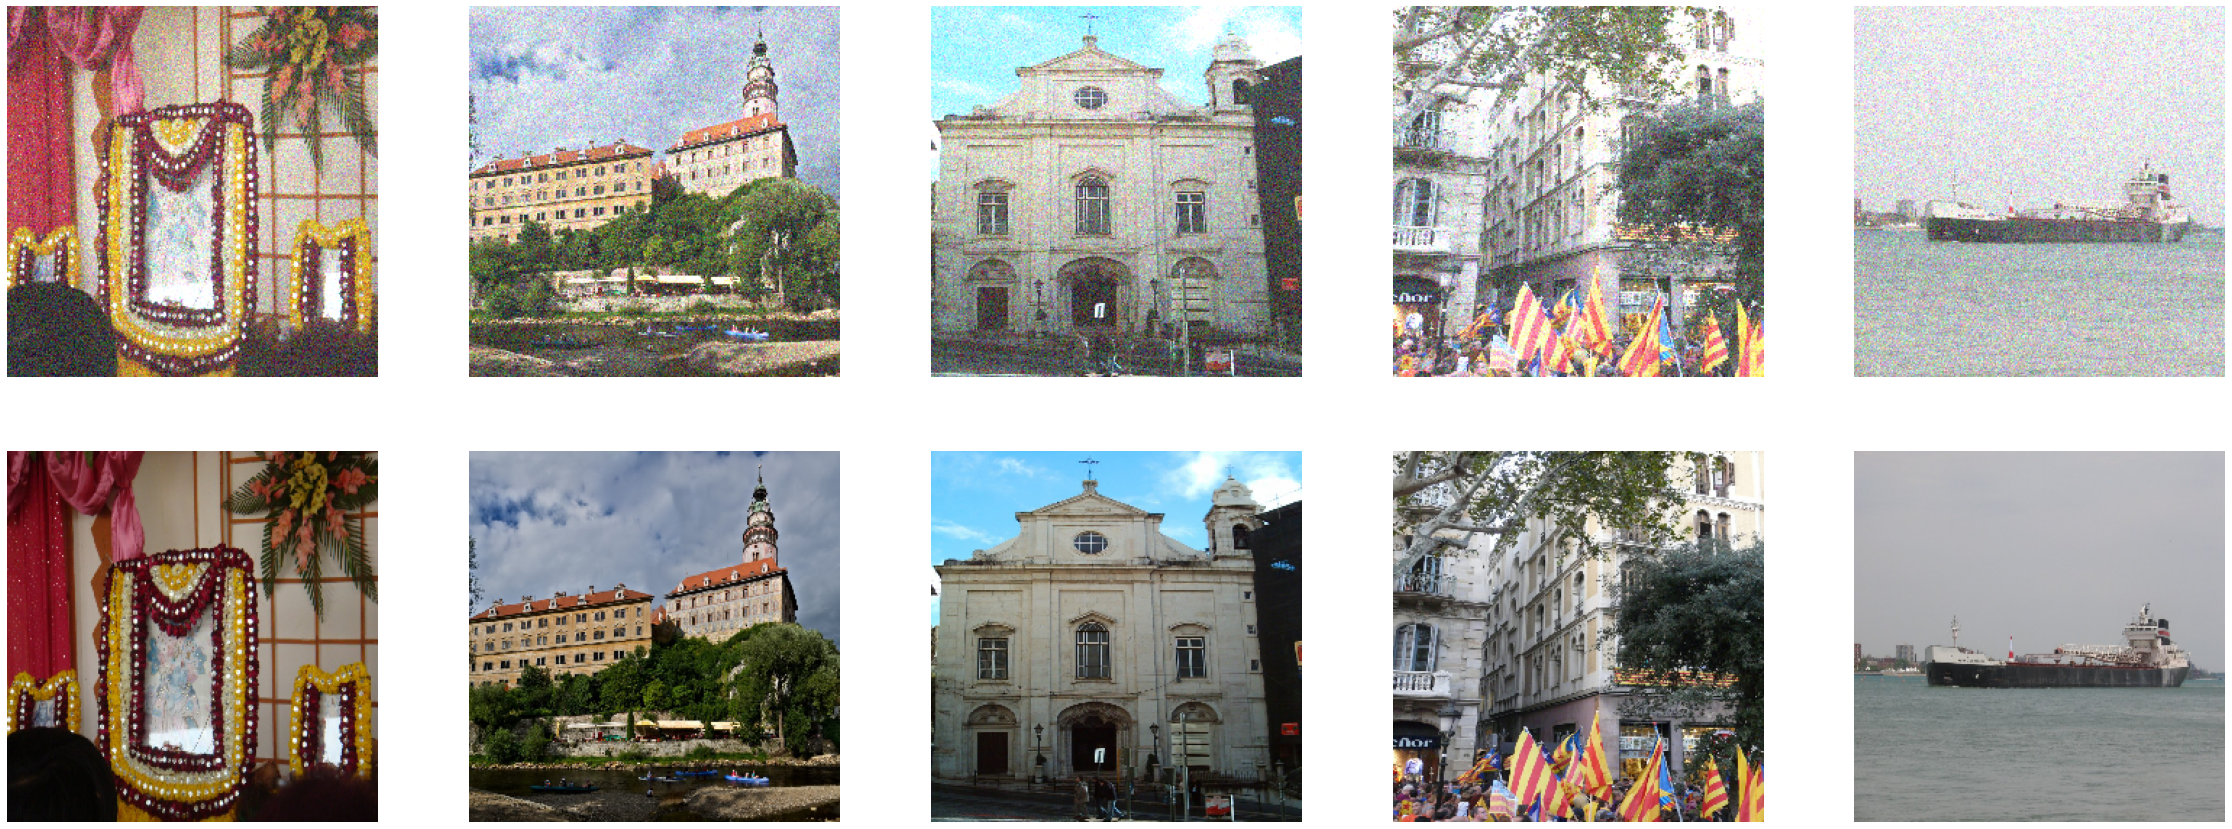

In [ ]:

import matplotlib.pyplot as plt

n = 5

plt.figure(figsize=(40, 15))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(testNoisyImages[i])
    ax.axis('off')

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(testOrgImages[i])
    ax.axis('off')
    

plt.show()

Model 11 katman olarak oluşturulur. Her katmanda batch normalization kullanılır.

In [ ]:
import keras.layers as layers
import keras.models as models
from keras.initializers import orthogonal

def DenoisingAutoencoder():
    
    
    inputs_layer = layers.Input(shape=(256,256, 3))

    # encoder
    x= layers.Conv2D(64, (3, 3), padding='same')(inputs_layer)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2,)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2,)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    
    # decoder
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2,)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    
    x= layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2,)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    output_layer = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return models.Model(inputs=inputs_layer, outputs=output_layer)

In [ ]:
from keras.optimizers import SGD, Adam

model = DenoisingAutoencoder()
model_opt = Adam(lr=0.00001)
#model_opt = SGD(lr=0.0001)
model.compile(optimizer=model_opt, loss='mse', metrics=['accuracy'])

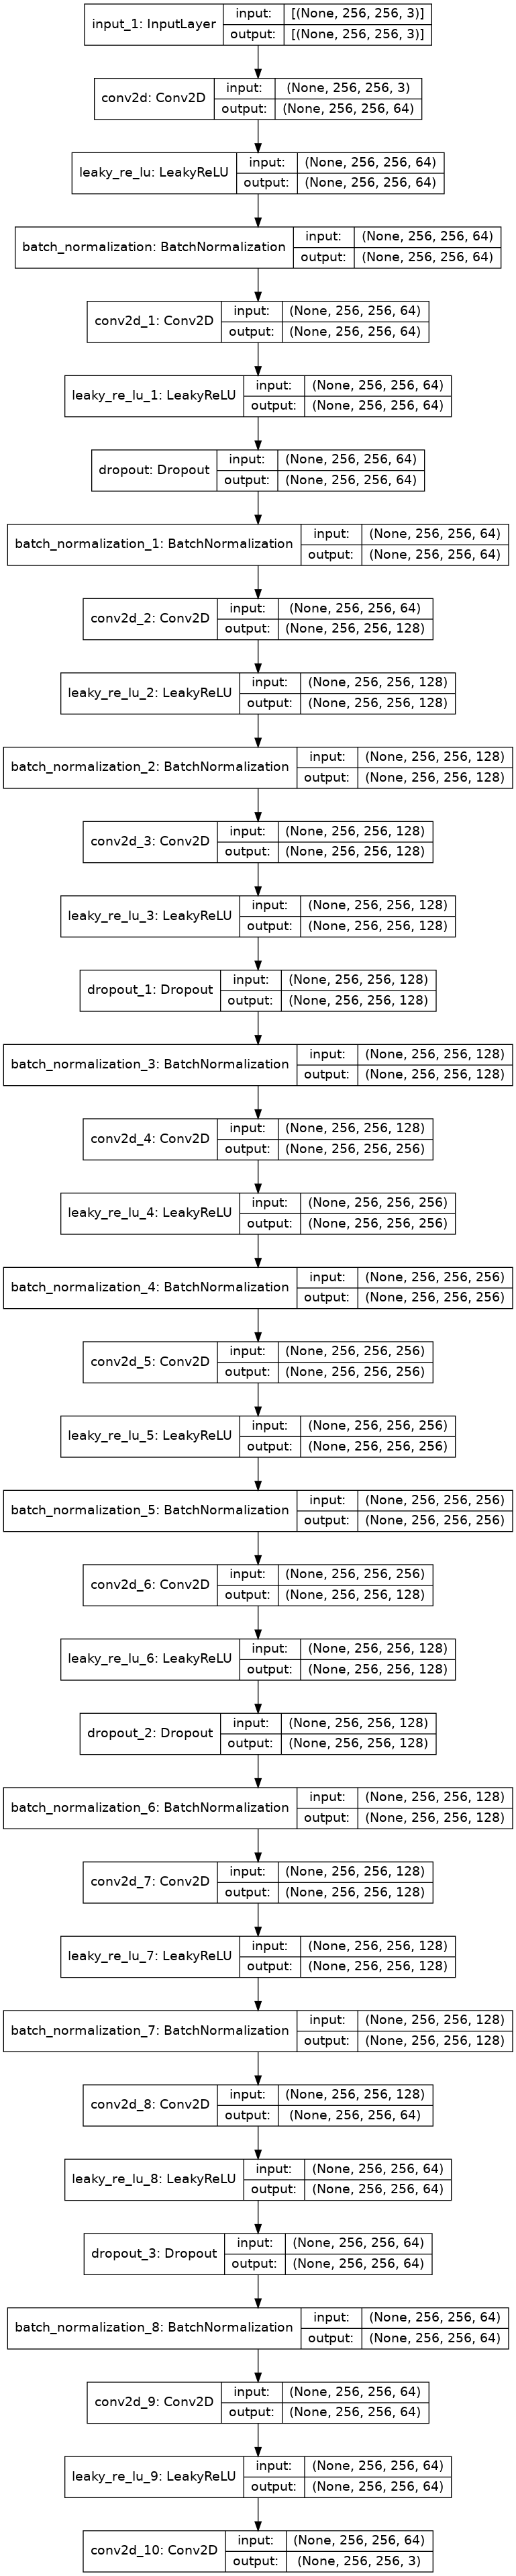

In [ ]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,to_file="model.png")

Görüntülere gürültü eklenerek batch'lere ayrılır.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,)

trainImages= train_datagen.flow_from_directory(
    dataset_path + '/train/train',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='input',
interpolation='nearest',)

val_datagen = ImageDataGenerator(rescale=1/255,)

valImages = val_datagen.flow_from_directory(
    dataset_path + '/val/val',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='input',
interpolation='nearest',)


trainNoisyBatch = GaussNoise(trainImages)
valNoisyBatch = GaussNoise(valImages)

Found 10000 images belonging to 1 classes.
Found 1041 images belonging to 1 classes.


In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./",
                                                 save_weights_only=True,
                                                 verbose=1)

Model eğitimi yapılır. Epoch değeri 20 seçilir.

In [ ]:
try:
    new_model = tf.keras.models.load_model('my_model.h5')
    
except:
    history =model.fit(trainNoisyBatch,
          steps_per_epoch = trainImages.samples // batch_size,
          epochs=20,
          verbose=1, 
          validation_data=valNoisyBatch,
          validation_steps = valImages.samples // batch_size,
        callbacks=[cp_callback]
         )
    model.save('my_model.h5')
    



Model kaydedilir.

In [ ]:
new_model = tf.keras.models.load_model('my_model.h5')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255,)

testImages = test_datagen.flow_from_directory(
    dataset_path + '/test',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='input',
interpolation='nearest',)

testNoisyBatch = GaussNoise(testImages)

In [ ]:
testNoisyImages, testOrgImages = next(testNoisyBatch)

Test verileri üzerinde sonuç kontrol edilir.

In [ ]:
score = new_model.evaluate(testNoisyImages, testOrgImages, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
decoded_imgs = new_model.predict(testNoisyImages)

In [ ]:
n = 5

plt.figure(figsize=(30, 13))
for i in range(3):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(testNoisyImages[i+5])
    
    plt.xlabel("Noisy")

    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i+5])
    
    plt.xlabel("Retored ")
    
    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.imshow(testOrgImages[i+5])
    plt.xlabel("Orginal ")
    

plt.show()